# Implementation of Recurrent Neural Networks from Scratch

Implementation of an RNN from scratch for a character-level language model.
The model will be trained on H. G. Wells' *The Time Machine*.


In [73]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import random
import torch
from torch import nn
from torch.nn import functional as F
from d2l.torch import load_data_time_machine, Accumulator, Animator, Timer

In [4]:
class History:
    """Accumulates values in a dictionary of sequences."""
    def __init__(self, keys):
        self.data = {}
        self.keys = keys
        for k in self.keys:
            self.data[k] = []

    def add(self, *args):
        for k,a in zip(self.keys, args):
            self.data[k].append(a)

    def sums(self):
        return {k: sum(self.data[k]) for k in self.keys}

    def merge(self, d):
        for k in self.keys:
            self.data[k].extend(d[k])

    def __getitem__(self, k):
        return self.data

In [5]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [6]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
n_tokens = len(vocab)

Each of the _batch_size_ items in a batch is a sequence of _num_steps_ tokens (characters), each identified by a token_id integer. The corresponding target is the sequence of _num_steps_ tokens derived from shifting the sequence one token right in the original text

In [7]:
batch_item = next(iter(train_iter))

In [8]:
batch_item

(tensor([[ 1, 21, 19,  ...,  1, 16,  7],
         [12,  2,  8,  ..., 10,  1, 18],
         [10,  2, 16,  ...,  5, 10,  2],
         ...,
         [ 1,  3,  2,  ...,  1,  8,  2],
         [ 8,  7, 13,  ...,  3,  4,  6],
         [21, 12,  2,  ...,  9,  2,  1]]),
 tensor([[21, 19,  1,  ..., 16,  7, 10],
         [ 2,  8,  1,  ...,  1, 18, 12],
         [ 2, 16,  5,  ..., 10,  2, 11],
         ...,
         [ 3,  2, 12,  ...,  8,  2,  2],
         [ 7, 13,  2,  ...,  4,  6, 15],
         [12,  2,  1,  ...,  2,  1, 11]]))

In [8]:
batch_item[0][0]

tensor([ 2,  1,  3,  5, 13,  2,  1,  3, 10,  4, 22,  2, 12, 12,  2, 10,  1, 16,
         7, 10,  1,  8,  7,  1,  5,  3,  1, 17,  5, 12, 12,  1, 21,  2,  1])

In [9]:
batch_item[1][0]

tensor([ 1,  3,  5, 13,  2,  1,  3, 10,  4, 22,  2, 12, 12,  2, 10,  1, 16,  7,
        10,  1,  8,  7,  1,  5,  3,  1, 17,  5, 12, 12,  1, 21,  2,  1, 15])

A dictionary associating the number of occurrences to each token is also available

In [10]:
vocab.token_freqs

[(' ', 29927),
 ('e', 17838),
 ('t', 13515),
 ('a', 11704),
 ('i', 10138),
 ('n', 9917),
 ('o', 9758),
 ('s', 8486),
 ('h', 8257),
 ('r', 7674),
 ('d', 6337),
 ('l', 6146),
 ('m', 4043),
 ('u', 3805),
 ('c', 3424),
 ('f', 3354),
 ('w', 3225),
 ('g', 3075),
 ('y', 2679),
 ('p', 2427),
 ('b', 1897),
 ('v', 1295),
 ('k', 1087),
 ('x', 236),
 ('z', 144),
 ('j', 97),
 ('q', 95)]

### One-Hot Encoding
Each token is encoded as a binary vector of length equal to the vocabulary size.


In [11]:
F.one_hot(batch_item[0][0,0], n_tokens)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

The shape of the minibatch that we sample each time is (_batch_size_, _num_steps_).
The `one_hot` function transforms such a minibatch into a three-dimensional tensor with shape (_batch_size_, _num_steps_, _n_tokens_).



In [12]:
F.one_hot(batch_item[0], n_tokens).shape

torch.Size([32, 35, 28])

We transpose the input so that we will obtain an output of shape (_num_steps_, _batch_size_, _n_tokens_)

This will allow to more conveniently loop through the outermost dimension for updating hidden states of a minibatch, time step by time step.

In [13]:
F.one_hot(batch_item[0].T, n_tokens).shape

torch.Size([35, 32, 28])

## Initializing the Model Parameters

The number of hidden units _num_hiddens_ of the RNN is a tunable hyperparameter.
When training language models, the inputs and outputs are from the same vocabulary.
Hence, they have the same dimension, which is equal to the vocabulary size.


In [9]:
def init_params(n_tokens, num_hiddens, device):
    num_inputs = num_outputs = n_tokens

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

To define an RNN model, we first need a function to return the hidden state at initialization.
It returns a tensor filled with 0 and with shape (_batch_size_, _num_hiddens_)


In [10]:
def init_state(batch_size, num_hiddens, device):
    return torch.zeros((batch_size, num_hiddens), device=device)

The RNN model loops through the outermost dimension of `inputs` so that it updates hidden states of a minibatch, time step by time step.
Besides, the activation function here uses the $\tanh$ function.


Let us check whether the outputs have the correct shapes, e.g., to ensure that the dimensionality of the hidden state remains unchanged.


In [16]:
num_hiddens = 512

device = try_gpu()

W_xh, W_hh, b_h, W_hq, b_q = init_params(n_tokens, num_hiddens, device)
state = init_state(batch_size, num_hiddens, device) # shape: (batch_size, num_hiddens)

X0 = batch_item[0]  # shape: (batch_size, num_steps)
X=F.one_hot(X0.T, n_tokens).type(torch.float32) # shape: (num_steps, batch_size, n_tokens)
H = state
outputs = []
for x in X: # for each time step
    H = torch.tanh(torch.mm(x, W_xh) + torch.mm(H, W_hh) + b_h)
    Y = torch.tanh(torch.mm(H, W_hq) + b_q)
    outputs.append(Y)
preds = torch.cat(outputs, dim=0) # shape: (num_steps x batch_size, n_tokens)


In [12]:
batch_size

32

In [13]:
print(H.shape)
print(preds.shape)

torch.Size([32, 512])
torch.Size([1120, 28])


Let us now encapsulate everything in a class

In [29]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, init_params, device='cpu'):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = init_params(vocab_size, num_hiddens, device)
        #self.init_state = init_state

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self._forward(X, state, self.params)

    def _forward(self, inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
        W_xh, W_hh, b_h, W_hq, b_q = params
        H = state
        outputs = []
        # Shape of `X`: (`batch_size`, `vocab_size`)
        for X in inputs:
            H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
            Y = torch.mm(H, W_hq) + b_q
            outputs.append(Y)
        return torch.cat(outputs, dim=0), H

    def init_state(self, batch_size, device='cpu'):
        return torch.zeros((batch_size, num_hiddens), device=device)

In [28]:
print(try_gpu())

cpu


In [31]:

num_hiddens = 512
net = RNNModelScratch(n_tokens, num_hiddens, init_params, try_gpu())
print(batch_size)
state = net.init_state(X0.shape[0], device)
preds, new_state = net(X0, state)

print(new_state.shape)
print(preds.shape)

32
torch.Size([32, 512])
torch.Size([1120, 28])


We can see that the output shape is (number of time steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).


## Prediction

Let us first define the prediction function
to generate new characters following
a user-provided _prefix_,
which is a string containing several characters.
When looping through these beginning characters in _prefix_,
we keep passing the hidden state
to the next time step without
generating any output.
This is called the *warm-up* period,
during which the model updates itself
(e.g., update the hidden state)
but does not make predictions.
After the warm-up period,
the hidden state is generally better than
its initialized value at the beginning.
So we generate the predicted characters and emit them.


In [33]:
prefix = 'time traveller '
prefix = 'in a hole in the ground there lived a hobbit not a nasty dirty wet hole filled with the ends of worms and an oozy smell nor yet a dry bare sandy hole with nothing in it to sit down on or to eat it was a hobbit hole and that means comfort '#
state = net.init_state(1)
outputs = [vocab[prefix[0]]]
get_input = lambda: torch.tensor([outputs[-1]]).reshape((1, 1))

In [34]:
state.shape

torch.Size([1, 512])

In [35]:
y = prefix[1]
z = get_input()
_, state = net(get_input(), state)

In [82]:
state.shape

torch.Size([1, 512])

In [37]:
def predict_seq(prefix, num_preds, net, vocab, device='cpu'):
    """Generate new characters following the prefix."""
    state = net.init_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

## Training
The model training procedure which is introduced here differs from how we train a MLP in three aspects:

### Sampling method
Different sampling methods for sequential data can be applied and  result in differences in the initialization of hidden states.

#### Random sampling
In random sampling, each example is a subsequence arbitrarily captured on the original long sequence.
The subsequences from two adjacent random minibatches during iteration are not necessarily adjacent on the original sequence.
The following code randomly generates a minibatch from the data each time.
Here, the argument _batch_size_ specifies the number of subsequence examples in each minibatch
and _num_steps_ is the predefined number of time steps
in each subsequence.

In [39]:
def seq_data_iter_random(seq, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    seq = seq[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(seq) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return seq[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

Let us manually generate a sequence from 0 to 34.
We assume that
the batch size and numbers of time steps are 2 and 5,
respectively.
This means that we can generate $\lfloor (35 - 1) / 5 \rfloor= 6$ feature-label subsequence pairs. With a minibatch size of 2, we only get 3 minibatches.

In [40]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[28, 29, 30, 31, 32],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[29, 30, 31, 32, 33],
        [19, 20, 21, 22, 23]])
X:  tensor([[23, 24, 25, 26, 27],
        [13, 14, 15, 16, 17]]) 
Y: tensor([[24, 25, 26, 27, 28],
        [14, 15, 16, 17, 18]])
X:  tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]])


#### Sequential partitioning
In addition to random sampling of the original sequence, we can also ensure that 
the subsequences from two adjacent minibatches
during iteration
are adjacent on the original sequence.
This strategy preserves the order of split subsequences when iterating over minibatches, hence is called sequential partitioning.

In [41]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

Using the same settings,
let us print features and labels for each minibatch of subsequences read by sequential partitioning.
Note that
the subsequences from two adjacent minibatches
during iteration
are indeed adjacent on the original sequence.

In [42]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


### Gradient Clipping

For a sequence of length $T$, we compute the gradients over these $T$ time steps in an iteration, which results in a chain of matrix-products with length  $\mathcal{O}(T)$ during backpropagation.
This might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.

Generally speaking, when solving an optimization problem, we take update steps for the model parameter,
say in the vector form $\mathbf{x}$, in the direction of the negative gradient $\mathbf{g}$ on a minibatch.
For example, with $\eta > 0$ as the learning rate, in one iteration we update $\mathbf{x}$
as $\mathbf{x} - \eta \mathbf{g}$.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$. But what if we only *rarely* get large gradients? In this case such an approach may appear entirely unwarranted. One popular alternative is to clip the gradient $\mathbf{g}$ by projecting them back to a ball of a given radius, say $\theta$ via

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

By doing so we know that the gradient norm never exceeds $\theta$ and that the
updated gradient is entirely aligned with the original direction of $\mathbf{g}$.

Below we define a function to clip the gradients of
a model. Note that we compute the gradient norm over all the model parameters.


In [44]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in net.params:
            param.grad[:] *= theta / norm

### Perplexity

We use perplexity to evaluate the model. Perplexity of a sequence $x_1,\ldots,x_n$ wrt a language model $P$ is strongly related to the cross-entropy loss averaged over all the $n$ tokens of the sequence:

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1)$$

This makes the performance on documents of different lengths comparable. Perplexity is indeed the exponential of such quantity:

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right)$$

Let us look at a number of cases:

* In the best case scenario, the model always perfectly estimates the probability of the label token as 1. In this case the perplexity of the model is 1.
* In the worst case scenario, the model always predicts the probability of the label token as 0. In this situation, the perplexity is $+\infty$.
* At the baseline, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary.

In [45]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [46]:
num_epochs, lr = 500, 1
updater = lambda batch_size: sgd(net.params, lr, batch_size)
loss = nn.CrossEntropyLoss()
state = None
X,Y = batch_item
state = net.init_state(batch_size=X.shape[0], device=try_gpu())
y = Y.T.reshape(-1)
y_hat, state = net(X, state)
l = loss(y_hat, y.long()).mean()
l.backward()
grad_clipping(net, 1)
updater(batch_size=1)


In [47]:
y_hat.shape

torch.Size([1120, 28])

In [88]:

num_hiddens = 512


In [48]:
num_epochs, lr = 500, 1
updater = lambda batch_size: sgd(net.params, lr, batch_size)
loss = nn.CrossEntropyLoss()

In [49]:
def perplexity(cum_loss, n):
    math.exp(cum_loss, n)

In [50]:
def train_epoch(net, train_iter, loss, updater, use_random_iter, device='cpu'):
    """Train a net within one epoch."""
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    h_epoch = History(['loss', 'n_tokens'])
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.init_state(batch_size=X.shape[0], device=device)
        else:
            state.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        l.backward()
        grad_clipping(net, 1)
        updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
        h_epoch.add(float(l)*len(y), len(y))
    s = h_epoch.sums()
    #return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()#math.exp(s['loss'] / s['n_tokens']), s['n_tokens'] / timer.stop()
    return math.exp(s['loss'] / s['n_tokens']), s['n_tokens'] / timer.stop(), h_epoch

In [52]:

def train(net, train_iter, vocab, lr, num_epochs, use_random_iter=False, prefix = 'time traveler', device='cpu'):
    """Train a model."""
    h_batch = History(['loss', 'n_tokens'])
    h_train = History(['perplexity', 'speed', 'prediction'])
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs], figsize=(8, 6))
    # Initialize
    updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_seq(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed, h_epoch = train_epoch(net, train_iter, loss, updater, use_random_iter)
        pred = predict(prefix)
        if (epoch + 1) % 10 == 0:
            print(pred)
            animator.add(epoch + 1, [ppl])
        h_train.add(ppl, speed, pred)
        h_batch.merge(h_epoch.data)
    return h_train, h_batch

#### Applying sequential partitioning

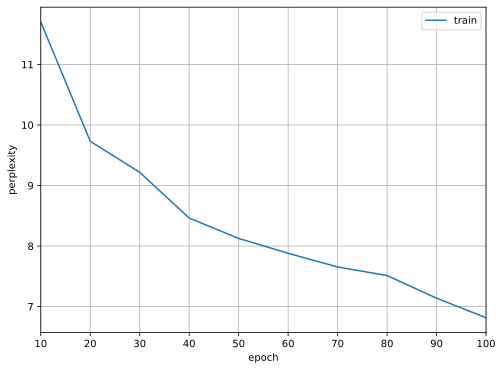

In [54]:
num_epochs, lr = 100, 1.5
net = RNNModelScratch(n_tokens, num_hiddens, init_params, device=try_gpu())
h_train_s, h_batch_s = train(net, train_iter, vocab, lr, num_epochs, device=try_gpu())

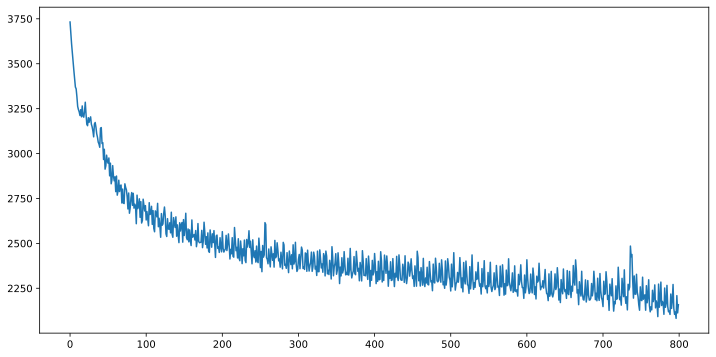

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(h_batch_s.data['loss'])

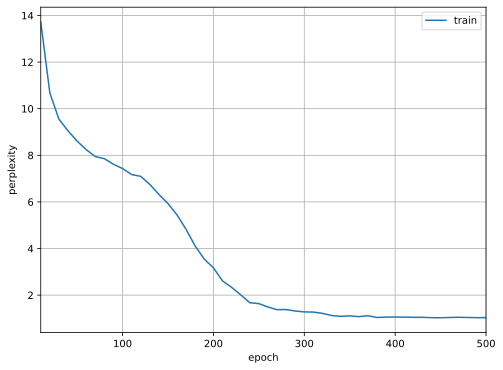

In [56]:

num_epochs, lr = 500, 1
net0 = RNNModelScratch(n_tokens, num_hiddens, init_params, device=try_gpu())
h_train, h_batch = train(net0, train_iter, vocab, lr, num_epochs, use_random_iter=False, device=try_gpu())

In [57]:
h_train.data['perplexity']

[24.773557352592096,
 19.732749923945605,
 17.80681700890508,
 17.55621473760177,
 17.17190201649287,
 16.675097101716382,
 16.127343850977226,
 15.249406151921615,
 14.453520024177497,
 13.721369294031124,
 12.97063934265342,
 12.413398171265824,
 12.058755647683265,
 11.642367202035127,
 11.532566499212646,
 11.23439709197599,
 11.094952401870117,
 10.984134902005978,
 10.64329919449574,
 10.675136320174868,
 10.421111337631022,
 10.46985517245395,
 10.33837434361036,
 10.181127982862801,
 10.042703195752415,
 10.060131334902163,
 9.9140180796363,
 9.727666268313657,
 9.818644729198429,
 9.549907864758278,
 9.535632858517314,
 9.426984969712306,
 9.35823931731242,
 9.291658255422773,
 9.194078108678024,
 9.232500769978378,
 9.102558967260407,
 9.108312951045704,
 8.992518763864712,
 9.048248322412999,
 8.942635549395769,
 8.819788324199433,
 8.887354647710376,
 8.831002590484259,
 8.782163997741632,
 8.732893549026246,
 8.696234158765018,
 8.715699210670463,
 8.637992096577529,
 8.60

In [59]:
df_train = pd.DataFrame.from_dict(h_train.data)

<AxesSubplot:>

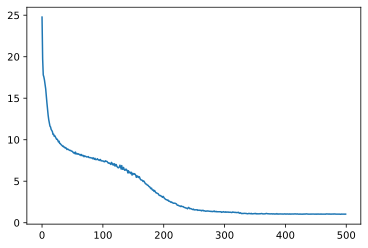

In [66]:
df_train.perplexity.plot()

In [58]:
predict_seq('killer lives inside me yes i can hear him move', 150, net0, vocab, device)

'killer lives inside me yes i can hear him move exterremele proceecerirew yor sard hew ol the piccedeag yoon ghan forethed hens aisatsoni at p andth antlysunsttattor ousted treface back for ana dit'

### Applying random partitioning


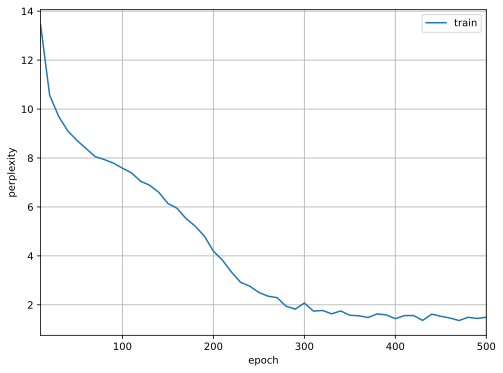

In [68]:
device = try_gpu()
net1 = RNNModelScratch(n_tokens, num_hiddens, init_params, device=try_gpu())
h_train, h_batch = train(net1, train_iter, vocab, lr, num_epochs, use_random_iter=True, device=try_gpu())


In [69]:
df_train1 = pd.DataFrame.from_dict(h_train.data)

<AxesSubplot:>

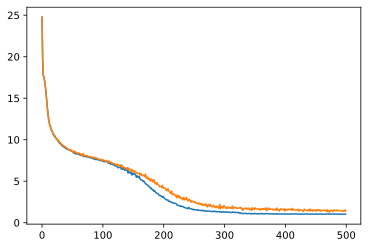

In [72]:
df_train.perplexity.plot()
df_train1.perplexity.plot()

In [70]:
predict_seq('killer lives inside me yes i can hear him move', 150, net1, vocab)

'killer lives inside me yes i can hear him mover deticus lownif lumoned letio i wavege tree is be and aly o murat and how heal haven thing the time travellerit s against reason said filbywa thatler'